import stuff here

In [1]:
from pyomo.environ import *
from itertools import product
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import sys
# append a new directory to sys.path
# sys.path.append("c:\\Users\\Tassili\\Desktop\\FSC-optimization-main")
# from QCLP_formulation import *
import networkx as nx
import os
os.environ['NEOS_EMAIL'] = 'malikbf5@gmail.com' 


# General two-armed Bernoulli Bandits

  Credits: Andrea Mazzolini, Alberto Pezzotta 

In the standard "two-armed Bernoulli Bandits" we can pull one of the two arms of a bandit (slot-machine) $a\in \lbrace 1,2 \rbrace$. Both the arms provide a Bernoulli-distributed reward: $r = 1$ with probability $q_i$, $r = 0$ with $1-q_i$, where $i \in \lbrace 1,2 \rbrace$.

<div>
<img src="Bandits.PNG" width="200">
</div>

There is a whole 2D space of possible bandits.
Each point correspond to a single state, that is a single realization of the two-bandits above.

<div>
<img src="BeliefSpace.PNG" width="200">
</div>
Solving each problem is trivial: we just use the arm with larger success probability.

In our case we'll consider two possible states to be in (state A and B) where each state is characterized by its winning probabilities for each arm which we'll denote as $\theta$, so state A is characterized by ($\theta_{A,1}, \theta_{A,2}$) and for B ($\theta_{B,1}, \theta_{B,2}$)

By choosing random values of $\theta$ for each arm we get the following states:

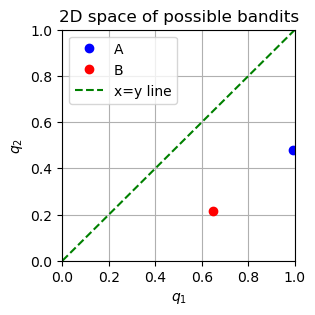

In [3]:
# Define the coordinates of the two points
point1 = np.random.uniform(0, 1, 2)
point2 = np.random.uniform(0, 1, 2)

# Extract x and y coordinates of each point
x1, y1 = point1
x2, y2 = point2

# Plot the points
plt.plot(x1, y1, 'bo', label='A')
plt.plot(x2, y2, 'ro', label='B')
plt.plot([0, 1], [0, 1], 'g--', label='x=y line')

# Set plot limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Add grid
plt.grid(True)

# Add labels and legend
plt.xlabel('$q_1$')
plt.ylabel('$q_2$')
plt.title('2D space of possible bandits')
plt.legend()

# set plot size
plt.gcf().set_size_inches(3, 3)
# Show plot
plt.show()
